In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import tarfile
import os

if not os.path.exists('/content/drive/My Drive/UFRGS/Learnability/relu'):
  with tarfile.open('/content/drive/My Drive/UFRGS/Learnability/neurons_relu.tar.gz', "r:gz") as nr:
    nr.extractall(path='/content/drive/My Drive/UFRGS/Learnability/relu')

if not os.path.exists('/content/drive/My Drive/UFRGS/Learnability/logistic'):
  with tarfile.open('/content/drive/My Drive/UFRGS/Learnability/neurons_logistic.tar.gz', "r:gz") as nr:
    nr.extractall(path='/content/drive/My Drive/UFRGS/Learnability/logistic')


In [2]:
# an example dataframe, note the repeated formulas
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/UFRGS/Learnability/logistic/neurons_logistic_v50_over_v50_c238_r4.760.csv')
df.head(4)

,formula,sampler,activation,#neurons,cvfolds,metric,mean,std,start,finish
0,sat_00100_k3_v50_c238.cnf_unigen_453_500.pkl.gz,unigen,logistic,1,5,accuracy,0.809424,0.233407,2020-08-28 11:31:28.548645,2020-08-28 11:31:29.442348
1,sat_00100_k3_v50_c238.cnf_unigen_453_500.pkl.gz,unigen,logistic,2,5,accuracy,0.998947,0.002105,2020-08-28 11:31:28.548645,2020-08-28 11:31:30.320994
2,sat_00100_k3_v50_c238.cnf_unigen_453_500.pkl.gz,unigen,logistic,4,5,accuracy,0.998947,0.002105,2020-08-28 11:31:28.548645,2020-08-28 11:31:31.254835
3,sat_00100_k3_v50_c238.cnf_unigen_453_500.pkl.gz,unigen,logistic,8,5,accuracy,1.000000,0.000000,2020-08-28 11:31:28.548645,2020-08-28 11:31:32.804640


In [3]:
# then we get the maximum #neurons of each formula (no repeated formulas anymore)
# note that none of those with 512 neurons has perfect accuracy
grouped_df = df.groupby("formula", sort=False, as_index=False).last()
print(len(grouped_df))
grouped_df.head(4)

173


,formula,sampler,activation,#neurons,cvfolds,metric,mean,std,start,finish
0,sat_00100_k3_v50_c238.cnf_unigen_453_500.pkl.gz,unigen,logistic,8,5,accuracy,1.00000,0.000000,2020-08-28 11:31:28.548645,2020-08-28 11:31:32.804640
1,sat_00009_k3_v50_c238.cnf_unigen_100_500.pkl.gz,unigen,logistic,8,5,accuracy,1.00000,0.000000,2020-08-28 11:31:32.804739,2020-08-28 11:31:35.884857
2,sat_00054_k3_v50_c238.cnf_unigen_54_500.pkl.gz,unigen,logistic,16,5,accuracy,1.00000,0.000000,2020-08-28 11:31:35.884958,2020-08-28 11:31:40.083207
3,sat_00102_k3_v50_c238.cnf_unigen_316_500.pkl.gz,unigen,logistic,512,5,accuracy,0.99878,0.002439,2020-08-28 11:31:40.083311,2020-08-28 11:32:03.657900


In [5]:
import numpy as np

df2 = df.where(df.sampler=='unigen').groupby('formula', sort=False, as_index=False).last()['#neurons'].value_counts(normalize=True,sort=False)
x = df2.index[np.argsort(df2.index)]
y = df2.values[np.argsort(df2.index)]


In [6]:
import matplotlib.pyplot as plt
from  matplotlib.ticker import PercentFormatter
%matplotlib inline
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


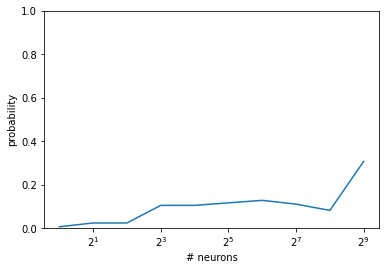

In [9]:
ax = sns.lineplot(x=x,y=y,markers=x)
from matplotlib.ticker import FixedLocator
xp = FixedLocator(x)
plt.gca().xaxis.set_major_locator(xp)
ax.set_ylim([0,1])
ax.set_xscale('log', basex=2)
ax.set_xlabel('# neurons')
ax.set_ylabel('probability')
ax

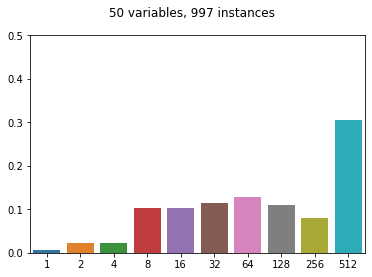

In [ ]:
ax = sns.barplot(x=x,y=y)
plt.suptitle(f'50 variables, {len(grouped_df)} instances')
ax.set_ylim([0,.5])
ax

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


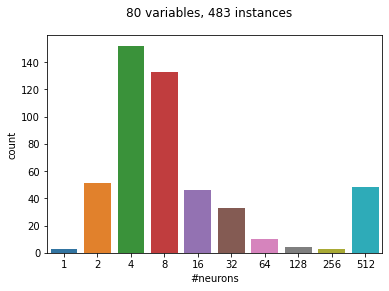

In [ ]:
# now, I'll plot a count of how many formulas were mastered with each number of neurons
plt.figure()
sns.countplot(x="#neurons", data=grouped_df) #kudos: https://stackoverflow.com/a/58021306/1251716
plt.suptitle(f'80 variables, {len(grouped_df)} instances')
pass # holds the output of suptitle

In [11]:
base_dir = '/content/drive/My Drive/UFRGS/Learnability'

In [14]:
from glob import glob
import os
import re
from tqdm import tqdm

def extract_vars_from_path(input):
  regex = r'neurons_(\w+)_v(\d+)_(\w+)_v\d+_c(\d+)_r(\d\.\d+)\.csv'
  pattern = re.compile(regex)
  activation, n_vars, pos, c, r = pattern.search(input).groups()
  return dict(activation=activation, vars=int(n_vars), phase=pos, clauses=int(c), ratio=float(r))




all_data = []

for f in tqdm(glob(f'{base_dir}/**/*.csv',recursive=True)):
  reg = extract_vars_from_path(os.path.basename(f))
  df = pd.read_csv(f)
  grouped_df = df.where(df.sampler == 'unigen').groupby("formula").last().reset_index()
  df2 = df.where(df.sampler=='unigen').groupby('formula', 
                                               sort=False, 
                                               as_index=False).last()['#neurons'].value_counts(
                                                   normalize=True,
                                                   sort=False)
  idx = np.argsort(df2.index)
  x = df2.index[idx]
  y = df2.values[idx]
  reg['x'] = np.int64(x)
  reg['y'] = y.astype('float')
  reg['neuron'] = np.int64(x[np.argmax(y)])
  reg['prob_neuron'] = np.float(y[np.argmax(y)])
  #print(reg)
  all_data.append(reg)


dt_out = pd.DataFrame.from_dict(all_data)

100%|██████████| 220/220 [00:09<00:00, 22.74it/s]


In [15]:
dt_out.to_pickle(f'{base_dir}/probabilities.pkl')
dt_out

,activation,vars,phase,clauses,ratio,x,y,neuron,prob_neuron
0,relu,10,over,59,5.90,[512],[1.0],512,1.000000
1,relu,10,onphase,55,5.50,[512],[1.0],512,1.000000
2,relu,10,over,58,5.80,[512],[1.0],512,1.000000
3,relu,10,under,51,5.10,[512],[1.0],512,1.000000
4,relu,10,under,53,5.30,[512],[1.0],512,1.000000
...,...,...,...,...,...,...,...,...,...
215,logistic,100,under,411,4.11,"[1, 2, 4, 8, 16, 32, 64, 128, 256, 512]","[0.16352201257861634, 0.26666666666666666, 0.1...",2,0.266667
216,logistic,100,under,401,4.01,"[1, 2, 4, 8, 16, 32, 64, 128, 256, 512]","[0.13253012048192772, 0.21248630887185105, 0.1...",512,0.359255
217,logistic,100,under,391,3.91,"[1, 2, 4, 8, 16, 32, 64, 128, 256, 512]","[0.07267144319344933, 0.15455475946775846, 0.1...",512,0.491300
218,logistic,100,over,451,4.51,"[1, 2, 4, 8, 16, 32, 64, 128, 256, 512]","[0.18181818181818182, 0.32386363636363635, 0.2...",2,0.323864


In [12]:
import numpy as np

dt_out = pd.read_pickle(f'{base_dir}/probabilities.pkl')

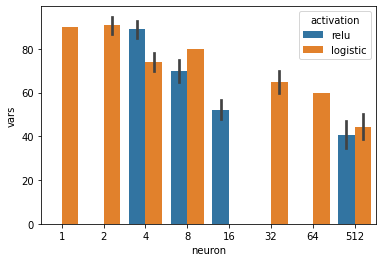

In [17]:
sns.barplot(x='neuron', y='vars',hue='activation', data=dt_out)

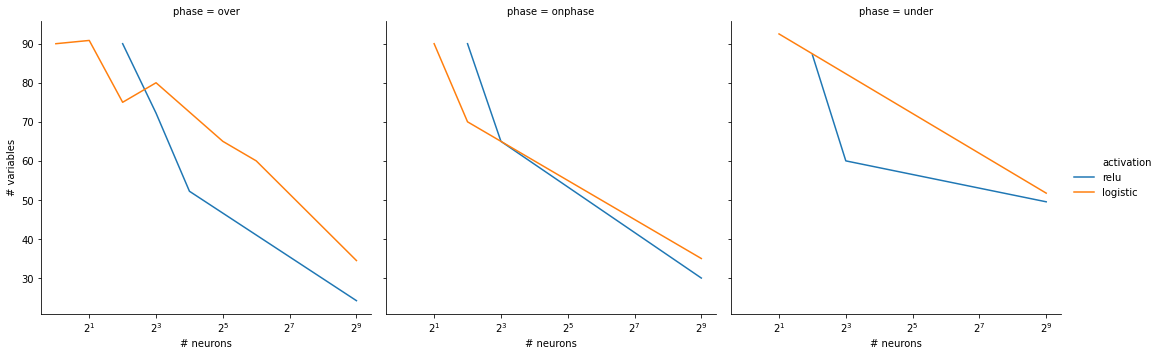

In [47]:
grid = sns.relplot(x="neuron", y="vars",
                 col="phase", hue="activation", err_style=None,
                 kind="line", data=dt_out)
grid.set(xlabel='# neurons', ylabel='# variables')

for ax in grid.axes.flat:
    ax.set_xscale('log', basex=2)

In [66]:
df3=dt_out.groupby(['activation', 'neuron'], sort=False).vars.value_counts(normalize=True,
                                                   sort=False)
pd.DataFrame(df3)

vars
activation neuron vars          
relu       512    10    0.166667
                  20    0.166667
                  30    0.166667
                  40    0.151515
                  50    0.090909
                  60    0.060606
                  70    0.060606
                  80    0.045455
                  90    0.045455
                  100   0.045455
           8      60    0.333333
                  70    0.416667
                  80    0.166667
                  90    0.083333
           16     40    0.111111
                  50    0.555556
                  60    0.333333
           4      70    0.086957
                  80    0.260870
                  90    0.304348
                  100   0.347826
logistic   512    10    0.135802
                  20    0.135802
                  30    0.135802
                  40    0.135802
                  50    0.135802
                  60    0.111111
                  70    0.074074
                  80    0.049383
                  90    0.049383
                  100   0.037037
           64     60    1.000000
           32     60    0.500000
                  70    0.500000
           2      70    0.052632
                  80    0.210526
                  90    0.315789
                  100   0.421053
           4      70    0.600000
                  80    0.400000
           8      80    1.000000
           1      90    1.000000

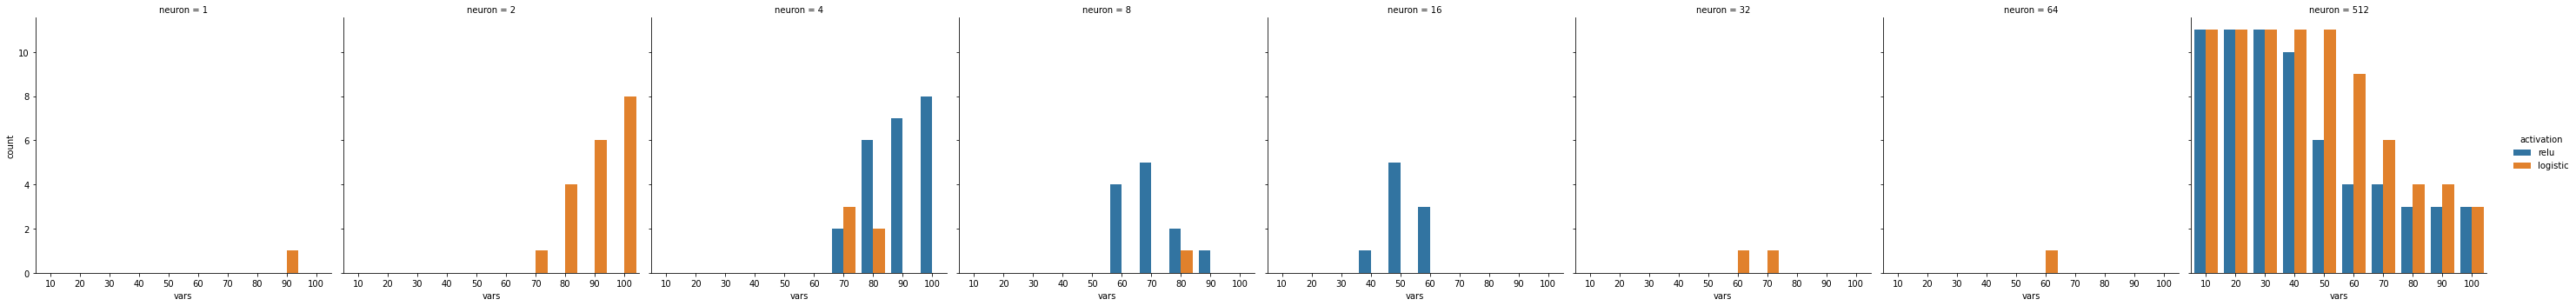

In [49]:
sns.catplot("vars", col="neuron",
                data=dt_out, hue="activation",
                kind="count")

## The problem is with multiple plots
Each will have a different number of instances (see code below), hence different y scales. I want the y axis in %

In [ ]:
import re
import os
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from  matplotlib.ticker import PercentFormatter
%matplotlib inline
import seaborn as sns
import numpy as np

def dir_string_ratio(dir_str):
    """
    Extracts the ratio on a directory string.
    Useful for sorting in increasing difficulty
    """
    pattern = re.compile(r"r(\d\.\d+)\.csv")
    return float(pattern.search(dir_str).group(1))

def plot_num_neurons(basedir, num_vars, activation):

    for f in sorted(glob(f'{basedir}/neurons_{activation}_v{num_vars}_*.csv'), key=dir_string_ratio):
        df = pd.read_csv(f)
        #df = df[df.sampler == 'unigen']  # gets only instances with 40+ solutions
        grouped_df = df.where(df.sampler == 'unigen').groupby("formula").last().reset_index()
        df2 = df.where(df.sampler=='unigen').groupby('formula', 
                                                     sort=False, 
                                                     as_index=False).last()['#neurons'].value_counts(
                                                         normalize=True,
                                                         sort=False)
        idx = np.argsort(df2.index)
        x = df2.index[idx]
        y = df2.values[idx]                                             

        plt.figure()
        #sns.countplot(x="#neurons", data=grouped_df) #kudos: https://stackoverflow.com/a/58021306/1251716
        #ax = sns.lineplot(x=x,y=y)
        ax = sns.barplot(x=x,y=y)
        plt.suptitle(f'{os.path.basename(f)}, {len(grouped_df)} instances')
        ax.set_ylim([0,1])
        ax.yaxis.set_major_formatter(PercentFormatter(1))
        #ax.set_xlim([0,515])
        ax
        #plt.show()
        #plt.savefig(f'/tmp/{g}_freq.pdf')



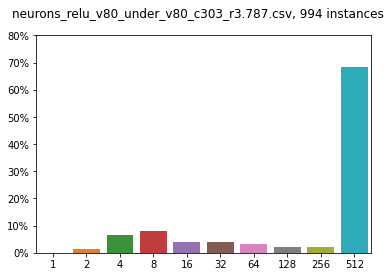

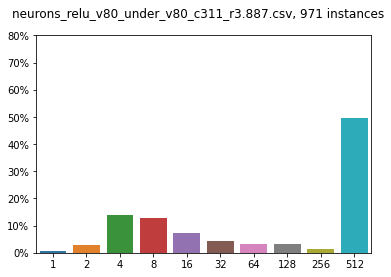

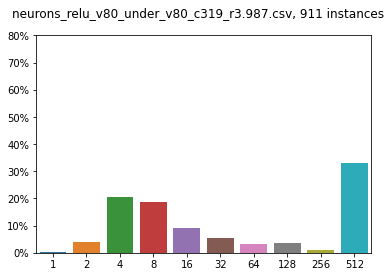

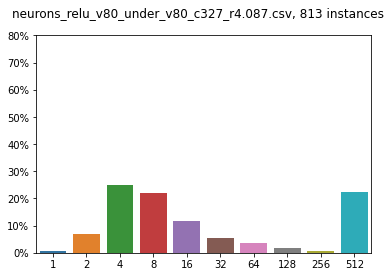

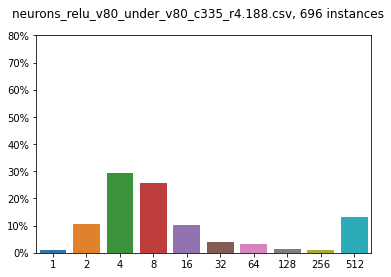

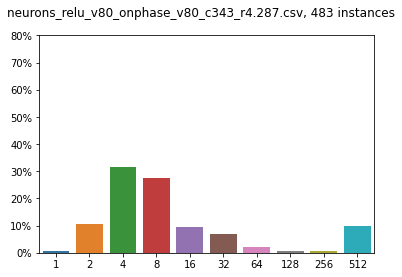

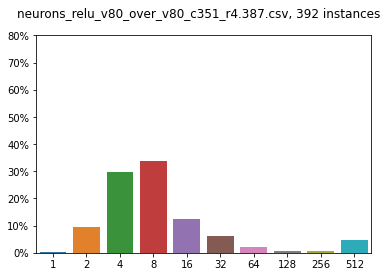

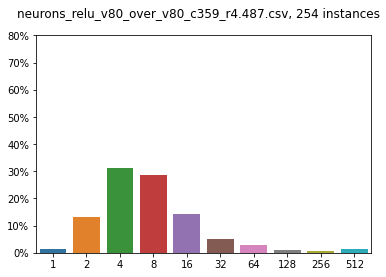

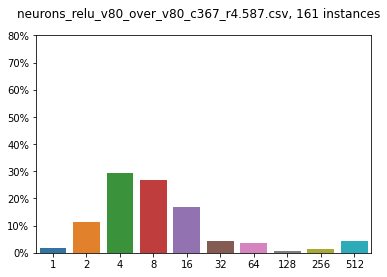

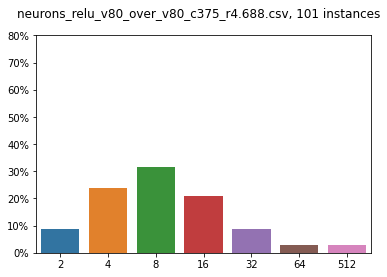

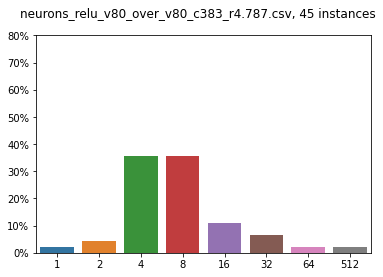

In [ ]:
plot_num_neurons('/content/drive/My Drive/UFRGS/Learnability/relu/', 80, 'relu')